In [4]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns
from trains import GeneralTrainer
from modules import MuLawEncoder
from model import WaveNet_Mel2Raw
from utils import weights_init_xavier_uniform, weights_init_norm
from dataset import load_ljspeech_dataset, load_speechcommand_dataset
result_dir = 'results'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [5]:
##
# Hyperparameters from config
from config import Config
config = Config()

In [6]:
##
# Datasets

# trainset, testset = load_speechcommand_dataset(config)
trainset, testset = load_ljspeech_dataset(config)
train_loader = DataLoader(trainset, batch_size=config.batch_size, pin_memory=True, shuffle=True, num_workers=config.num_workers)
test_loader = DataLoader(testset, batch_size=config.batch_size, pin_memory=True, num_workers=config.num_workers)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

print(device)

cuda


In [8]:
## 
# Initialize the model, optimizer, loss function

model = WaveNet_Mel2Raw.create_with(config)
weights_init_xavier_uniform(model)
# pre_net = MuLawEncoder(model.mu)

loss_func = nn.CrossEntropyLoss()
loss_func_wrapper = lambda p, t: loss_func(p[:, :min(p.size(-1), t.size(-1))], t[:, :min(p.size(-1), t.size(-1))])
optimizer_builder = lambda model:torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=0.0)

In [9]:
##
# Trainer
trainer = GeneralTrainer(model, 
                         optimizer_builder, 
                         loss_func_wrapper,
                        #  score_metric={'accuracy':accuracy_score}, 
                         score_metric={},
                        #  pre_net = pre_net,
                         checkpoint_dir=config.check_point_folder)

trainer.set_tqdm_for_notebook(True)

In [10]:
##
# if train_after is not None then load data and continue the train
reset = True
if config.train_after is not None:
    trainer.load_data( config.train_after)
    reset = False

In [ ]:
##
# Train
result = trainer.train(train_loader, val_loader=test_loader, epochs=config.epochs, device=device, reset=reset, cp_filename=config.check_point_file, cp_period=config.check_point_period, print_progress=True)

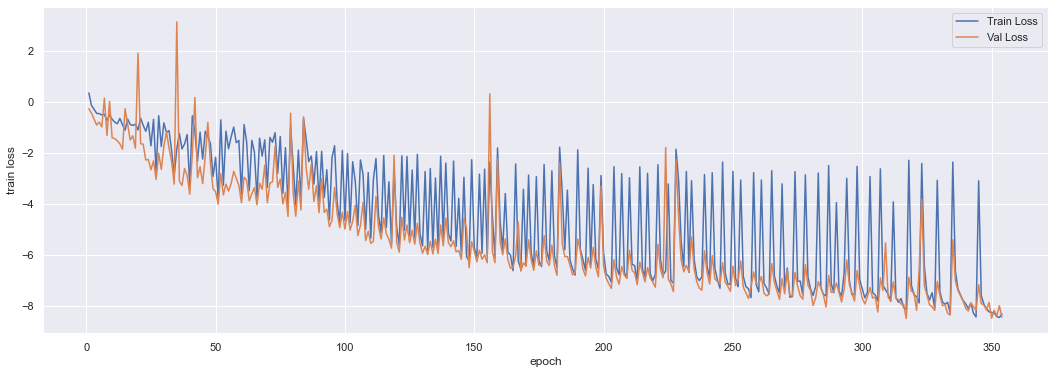

In [54]:
##
# plot the losses
result = trainer.get_result()
import numpy as np
result['train loss'] = np.log(result['train loss']) 
result['val loss'] = np.log(result['val loss']) 
sns.set(rc={'figure.figsize':(18,6)})
ax = sns.lineplot(x='epoch', y='train loss', data=result, label='Train Loss')
sns.lineplot(x='epoch', y='val loss', data=result, label='Val Loss')
plt.show()